In [1]:
import json
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import pyprojroot
import seaborn as sns

In [2]:
HVC_RESULTS_ROOT = pyprojroot.here() / 'results/Bengalese_Finches/hvc'
source_csv = HVC_RESULTS_ROOT / 'segment_error_across_birds.hvc.csv'

In [3]:
hvc_df = pd.read_csv(source_csv)
# hvc_df.rename(
#      columns={'train_dur': 'Training set duration (s)',
#               'mean_segment_error_rate': 'Segment error rate',
#               },
#     inplace=True)
hvc_df.rename(
     columns={
         'mean_segment_error_rate': 'avg_segment_error_rate',
         'train_dur': 'train_set_dur',
         'replicate': 'replicate_num',
              },
    inplace=True)

hvc_df['segmenting'] = hvc_df['source'].map({'ground_truth': 'Manually cleaned', 'resegment': 'Raw'})
hvc_df['model'] = 'SVM'

In [4]:
LEARNCURVE_RESULTS_ROOT = pyprojroot.here() / 'results' / 'Bengalese_Finches' / 'learncurve'
error_csv_path = LEARNCURVE_RESULTS_ROOT.joinpath('error_across_birds_with_cleanup.csv')
curve_df = pd.read_csv(error_csv_path)

curve_df = curve_df[curve_df.animal_id.isin(hvc_df.animal_id.unique())]
# curve_df.rename(
#     columns={'train_set_dur': 'Training set duration (s)',
#              'avg_segment_error_rate': 'Segment error rate',
#              },
#     inplace=True)
curve_df['model'] = 'TweetyNet'
curve_df['segmenting'] = 'None'

In [5]:
CLEANUP = 'min_segment_dur_majority_vote'

curve_df = curve_df[
    curve_df.cleanup == CLEANUP
]

In [6]:
all_df = pd.concat([hvc_df, curve_df])

In [7]:
all_df

,animal_id,train_set_dur,replicate_num,source,avg_segment_error_rate,segmenting,model,cleanup,avg_acc,avg_levenshtein,avg_pct_boundary_err,model_name,avg_error,train_set_dur_ind
0,bl26lb16,75,1,ground_truth,0.030212,Manually cleaned,SVM,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,bl26lb16,75,1,resegment,0.961620,Raw,SVM,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,bl26lb16,75,2,ground_truth,0.028416,Manually cleaned,SVM,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,bl26lb16,75,2,resegment,1.095086,Raw,SVM,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,bl26lb16,75,3,ground_truth,0.027670,Manually cleaned,SVM,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2222,or60yw70,45,6,NaN,0.023465,None,TweetyNet,min_segment_dur_majority_vote,0.976835,1.59375,0.719113,TweetyNet,2.316513,1.0
2226,or60yw70,45,7,NaN,0.028432,None,TweetyNet,min_segment_dur_majority_vote,0.977711,1.93750,0.709828,TweetyNet,2.228889,1.0
2230,or60yw70,45,8,NaN,0.042386,None,TweetyNet,min_segment_dur_majority_vote,0.969762,2.43750,0.613408,TweetyNet,3.023795,1.0
2234,or60yw70,45,9,NaN,0.026222,None,TweetyNet,min_segment_dur_majority_vote,0.977558,1.21875,0.730111,TweetyNet,2.244217,1.0


In [20]:
gb = all_df.groupby(by=['model', 'segmenting', 'animal_id', 'train_set_dur'])
df_agg = gb.agg(
    mean_seg_err = pd.NamedAgg('avg_segment_error_rate', 'mean'),
    std_seg_err = pd.NamedAgg('avg_segment_error_rate', 'std')
)

data = df_agg.reset_index()  # ``data`` DataFrame for use with ``seaborn``

In [10]:
data.model.unique()

array(['SVM', 'TweetyNet'], dtype=object)

In [11]:
FIG_ROOT = pyprojroot.here() / 'doc' / 'article' / 'figures' / 'mainfig_segment_models'

In [12]:
sns.set()

In [13]:
MODEL_HUE_MAP = {
    'SVM': 'blue',
    'TweetyNet': 'lawngreen',
}

In [26]:
data.columns

Index(['model', 'segmenting', 'animal_id', 'train_set_dur', 'mean_seg_err',
       'std_seg_err'],
      dtype='object')

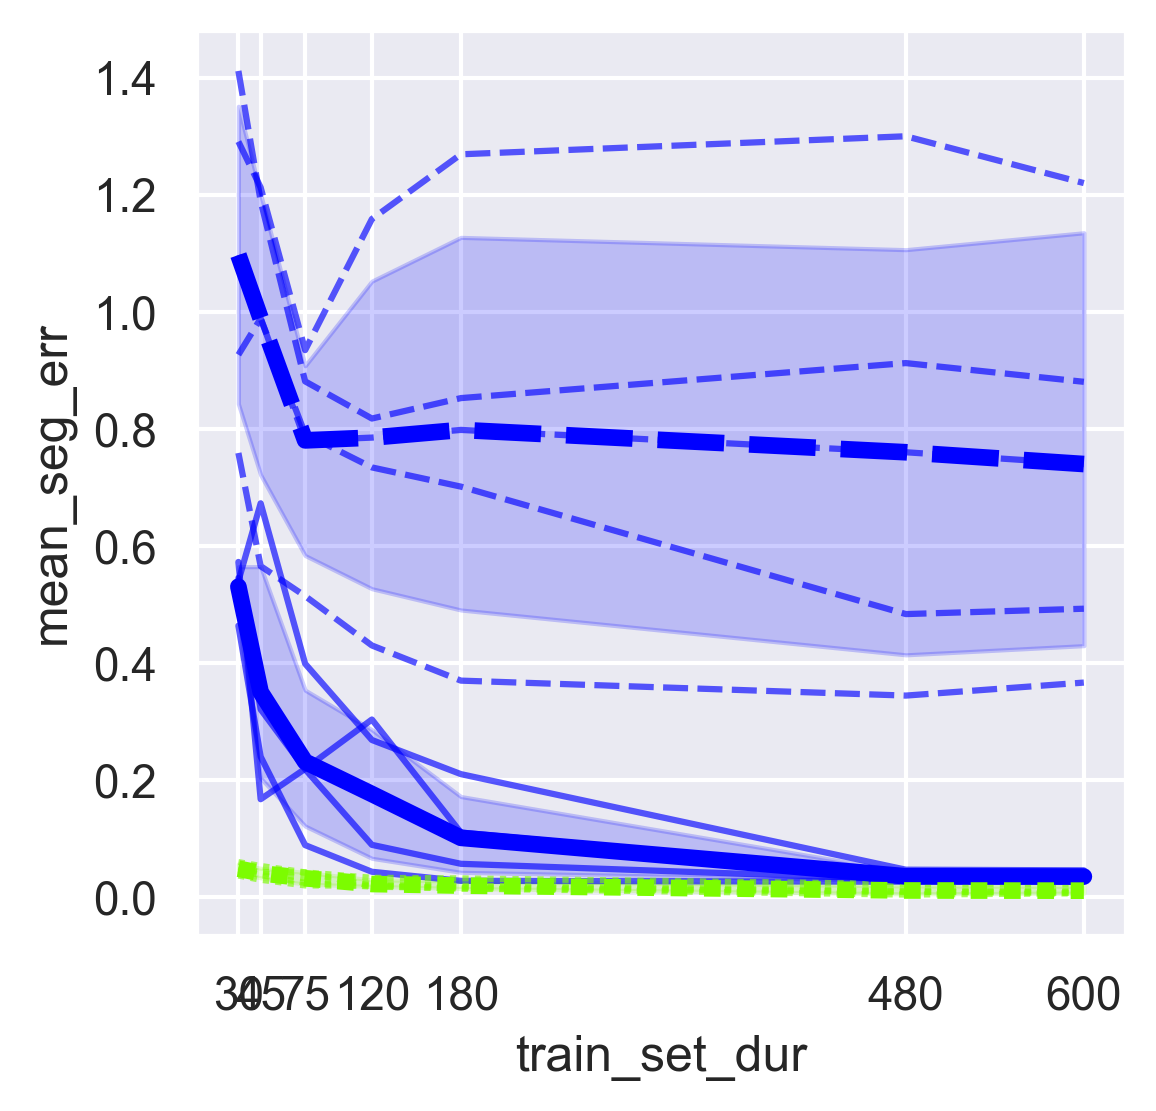

In [30]:
fig, ax = plt.subplots()

sns.lineplot(
    data=data,
    x='train_set_dur',
    y='mean_seg_err',
    hue='model',
    palette=MODEL_HUE_MAP,
    style='segmenting',
    units='animal_id',
    estimator=None,
    alpha=0.65,
    ax=ax,
    legend=False,
)


sns.lineplot(
    data=data,
    x='train_set_dur',
    y='mean_seg_err',
    hue='model',
    palette=MODEL_HUE_MAP,
    style='segmenting',
    alpha=0.65,
    ax=ax,
    legend=False,
)

sns.lineplot(x='train_set_dur',
             y='mean_seg_err',
             linewidth=4,
             style='segmenting',
             hue='model',
             palette=MODEL_HUE_MAP,
             data=data, 
             ci=None,
             ax=ax,
             legend=False)

# sns.lineplot(x='training set duration (s)',
#              y='segment error rate',
#              linestyle='dashed',
#              linewidth=4,
#              hue='source',
#              data=hvc_df, ci=None, label='mean', ax=ax, legend=False)

# sns.lineplot(x='Training set duration (s)',
#              y='Segment error rate',
#              linestyle='dashed',
#              color='lawngreen',
#              linewidth=4,
#              data=curve_df, 
#              ci='sd', 
#              label='min_segment_dur_majority_vote',
#              ax=ax, 
#              legend=False)

# g.axes[0][0].set_ylim([0., 1.5])

train_set_durs = sorted(data['train_set_dur'].unique())
ax.set_xticks(train_set_durs)
#ax.set_xticklabels(train_set_durs, rotation=45)
fig.set_dpi(300)
fig.set_size_inches(4,4)

FIG_STEM = 'segment-model-results'
    
# for ext in ('eps', 'pdf', 'svg'):
#     g.fig.savefig(FIG_ROOT / f'{FIG_STEM}.{ext}');

In [19]:
data

,model,segmenting,animal_id,replicate_num,train_set_dur,mean_seg_err,std_seg_err
0,SVM,Manually cleaned,bl26lb16,1,30,0.575295,NaN
1,SVM,Manually cleaned,bl26lb16,1,45,0.030375,NaN
2,SVM,Manually cleaned,bl26lb16,1,75,0.030212,NaN
3,SVM,Manually cleaned,bl26lb16,1,120,0.025909,NaN
4,SVM,Manually cleaned,bl26lb16,1,180,0.026330,NaN
...,...,...,...,...,...,...,...
835,TweetyNet,None,or60yw70,10,75,0.022279,NaN
836,TweetyNet,None,or60yw70,10,120,0.014986,NaN
837,TweetyNet,None,or60yw70,10,180,0.024292,NaN
838,TweetyNet,None,or60yw70,10,480,0.006937,NaN


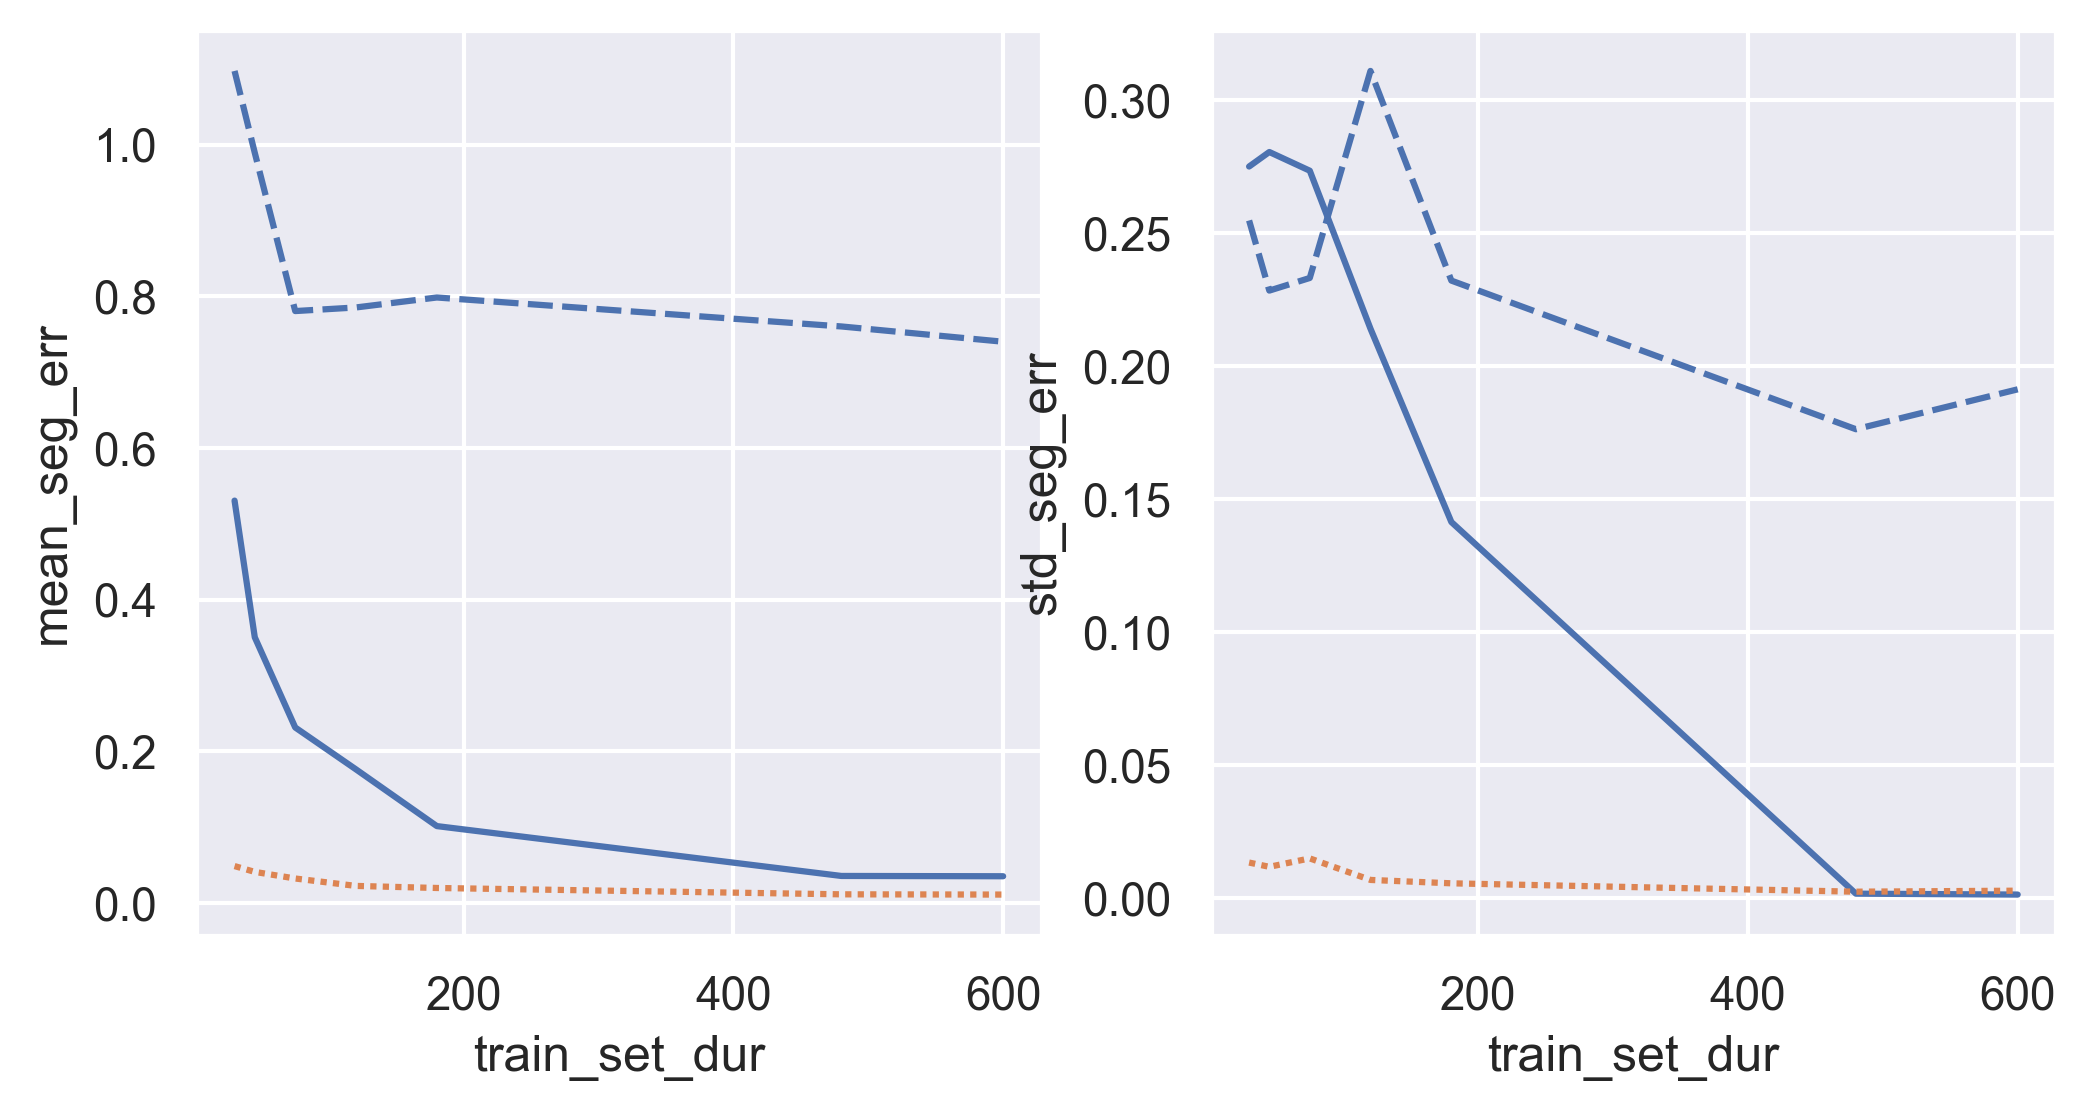

In [31]:
FIGSIZE = (8, 4)
DPI = 300

fig, ax_arr = plt.subplots(nrows=1, ncols=2, figsize=FIGSIZE, dpi=DPI)

sns.lineplot(x='train_set_dur',
             y='mean_seg_err',
             style='segmenting',
             hue='model',
             data=data, 
             ci=None,
             ax=ax_arr[0],
             legend=False)

sns.lineplot(x='train_set_dur',
             y='std_seg_err',
             style='segmenting',
             hue='model',
             data=data, 
             ci=None,
             ax=ax_arr[1],
             legend=False)

# g = sns.lineplot(x='Training set duration (s)',
#              y='Segment error rate',
#              linestyle='dashed',
#              color='lawngreen',
#              linewidth=4,
#              data=curve_df[curve_df.cleanup == 'min_segment_dur_majority_vote'], 
#              ci='sd', 
#              label='TweetyNet',
#              ax=ax_arr[0])

# g.legend(loc='center left', bbox_to_anchor=(1, 0.5))

#g.axes[0][0].set_ylim([0., 1.5])

# x='Training set duration (s)',
#              y='Segment error rate',

#g.axes[0][0].set_xticklabels(sorted(hvc_df['Training set duration (s)'].unique()), rotation=45)
#g.fig.set_dpi(200)

FIG_STEM = 'segment-model-results'
    
# for ext in ('eps', 'pdf', 'svg'):
#     g.fig.savefig(FIG_ROOT / f'{FIG_STEM}.{ext}');

## TODO: plot confusion matrices